In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from larq_compute_engine.tflite.python.interpreter import Interpreter #https://github.com/larq/compute-engine/blob/v0.8.0/larq_compute_engine/tflite/python/interpreter.py#L6

2024-07-24 14:43:39.000917: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 14:43:39.285764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 14:43:39.285811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 14:43:39.341753: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 14:43:39.458288: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 14:43:39.459861: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
import larq_compute_engine as lce
import tensorflow as tf
import larq as lq
import numpy as np
# from tensorflow_model_optimization.python.core.keras.compat import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import random
tf.random.set_seed(3407)
np.random.seed(3407)
random.seed(3407)

from create_spectrogram import (
    create_spectrograms_from_audio_dataset, 
)
from helper_functions import (
    evaluate_prediction,
    get_file_size, 
    convert_bytes, 
    convert_prefetchdataset_to_numpy_arrays,
    predict_and_print_full_results,
    evaluate_time_of_prediction
    )

In [4]:
sample_rate = 16000

In [5]:
train_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/training", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)
test_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/testing", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)
val_dataset = tf.keras.utils.audio_dataset_from_directory("dataset/validation", labels='inferred', sampling_rate=16000, batch_size=32, shuffle=True, seed=3407)

label_names = np.array(train_dataset.class_names)
print("Classes: ", label_names)

Found 11292 files belonging to 2 classes.


2024-07-24 14:43:44.585946: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-24 14:43:44.586843: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-07-24 14:43:44.720032: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
2024-07-24 14:43:44.790995: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


Found 1393 files belonging to 2 classes.
Found 1380 files belonging to 2 classes.
Classes:  ['non_target' 'target']


In [6]:
train_spectrogram_ds = create_spectrograms_from_audio_dataset(train_dataset, sample_rate = sample_rate).cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = create_spectrograms_from_audio_dataset(test_dataset, sample_rate = sample_rate).cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = create_spectrograms_from_audio_dataset(val_dataset, sample_rate = sample_rate).cache().prefetch(tf.data.AUTOTUNE)

x_train_np, y_train_np = convert_prefetchdataset_to_numpy_arrays(train_spectrogram_ds)
x_val_np, y_val_np = convert_prefetchdataset_to_numpy_arrays(val_spectrogram_ds)
x_test_np, y_test_np = convert_prefetchdataset_to_numpy_arrays(test_spectrogram_ds)

tf.Tensor([0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0], shape=(32,), dtype=int32)
0
tf.Tensor([0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)
0
tf.Tensor([1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0], shape=(32,), dtype=int32)
1


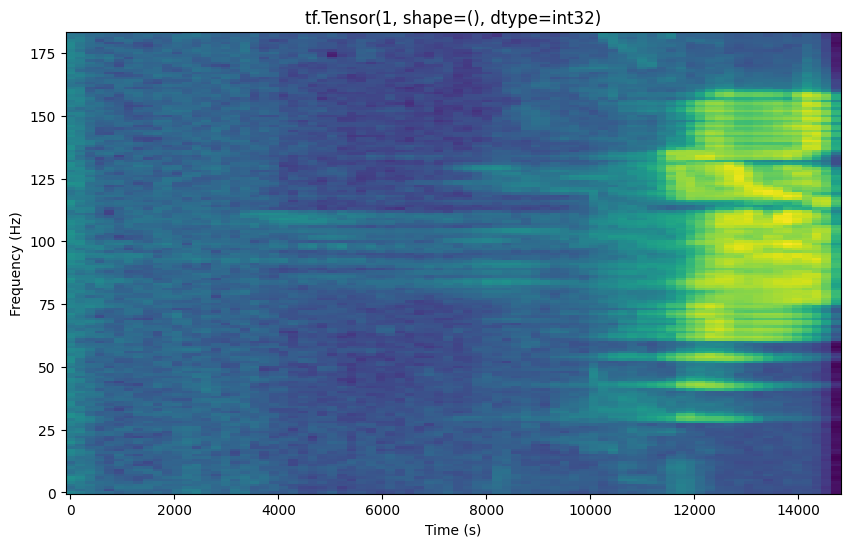

In [8]:
# non-target = 0, target = 1
# Print spectrograms of target or non-target class from dataset
class_number = 1

for i in train_spectrogram_ds:
    print(i[1])
    print(i[1][0].numpy())
    if i[1][0].numpy() == class_number:
        spectrogram = i[0][0]
        height = spectrogram.shape[0]
        width = spectrogram.shape[1]
        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
        Y = range(height)
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(X, Y, spectrogram)
        plt.title(i[1][0])
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()
        break

### Binarized NN

In [31]:
# Following Larq's documentation model depth and parameters
model = tf.keras.models.Sequential()

# The first layer, only the weights are quantized while activations are left full-precision
model.add(lq.layers.QuantConv2D(4, (3, 3),
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=(184, 80, 1)))

model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))

# The second layer has both quantized weights and activations using the Straight-through-estimator sign activation technquie.
# Using straight-through-estimator to overcome undifferentiability issues
model.add(lq.layers.QuantConv2D(8, (3, 3), use_bias=False, input_quantizer="ste_sign",kernel_quantizer="ste_sign",kernel_constraint="weight_clip"))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))

# The third layer following the second layer
# model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, input_quantizer="ste_sign",kernel_quantizer="ste_sign",kernel_constraint="weight_clip"))
# model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())
# The fourth layer
model.add(lq.layers.QuantDense(16, use_bias=False, input_quantizer="ste_sign",kernel_quantizer="ste_sign",kernel_constraint="weight_clip"))
model.add(tf.keras.layers.BatchNormalization(scale=False))
# The fifth layer
model.add(lq.layers.QuantDense(2, use_bias=False, input_quantizer="ste_sign",kernel_quantizer="ste_sign",kernel_constraint="weight_clip"))
model.add(tf.keras.layers.BatchNormalization(scale=False))
#Output layer, multi class classification
model.add(tf.keras.layers.Activation("softmax"))



#Compile and train the network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [32]:
# Evaluate the network
lq.models.summary(model)

+sequential_1 stats----------------------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs  32-bit MACs |
|                              (bit)                        x 1       x 1    (kB)                          |
+----------------------------------------------------------------------------------------------------------+
| quant_conv2d_2                   -  (-1, 182, 78, 4)       36         0    0.00           0       511056 |
| max_pooling2d_2                  -   (-1, 91, 39, 4)        0         0       0           0            0 |
| batch_normalization_4            -   (-1, 91, 39, 4)        0         8    0.03           0            0 |
| quant_conv2d_3                   1   (-1, 89, 37, 8)      288         0    0.04      948384            0 |
| max_pooling2d_3                  -   (-1, 44, 18, 8)        0         0       0           0            0 |
| batch_normalizati

In [34]:
model.fit(train_spectrogram_ds, epochs=1)

353/353 [==============================] - 15s 41ms/step - loss: 0.5135 - accuracy: 0.7697


In [39]:
def display_weights(model):
    for layer in model.layers:
        # if isinstance(layer, lq.layers.QuantConv2D) or isinstance(layer, lq.layers.QuantDense):
        weights = layer.get_weights()
        if weights:
            print(f"Layer: {layer.name}")
            for weight in weights:
                print(f"Shape: {weight.shape}")
                # Print the unique values to see if they are binarized
                unique_values = np.unique(weight)
                print(f"Unique values: {unique_values}\n")
                # Print the first few weights for inspection
                print(f"First few weights: {weight.flatten()[:10]}\n")

# Display the weights of the binarized CNN model


def model_memory_usage(model):
    import sys
    import larq as lq

    total_size = 0
    for layer in model.layers:
        if isinstance(layer, (lq.layers.QuantConv2D, lq.layers.QuantDense)):
            weights = layer.get_weights()
            for weight in weights:
                size = sys.getsizeof(weight)
                total_size += size
                print(f"Layer: {layer.name}, Weight shape: {weight.shape}, Size: {size} bytes")

    print(f"Total memory usage: {total_size} bytes")

# Display the weights of the binarized CNN model
display_weights(model)

# Check the memory usage of the model
model_memory_usage(model)


Layer: quant_conv2d_2
Shape: (3, 3, 1, 4)
Unique values: [-1.  1.]

First few weights: [-1. -1. -1.  1.  1. -1.  1. -1.  1. -1.]

Layer: batch_normalization_4
Shape: (4,)
Unique values: [-0.13683645 -0.08698536 -0.07958774  0.09291819]

First few weights: [ 0.09291819 -0.08698536 -0.07958774 -0.13683645]

Shape: (4,)
Unique values: [-4.1779475 -4.1173897  2.6977668  9.930045 ]

First few weights: [-4.1173897  2.6977668  9.930045  -4.1779475]

Shape: (4,)
Unique values: [  8.550764  66.66973   67.759415 172.82541 ]

First few weights: [ 67.759415   8.550764 172.82541   66.66973 ]

Layer: quant_conv2d_3
Shape: (3, 3, 4, 8)
Unique values: [-1.  1.]

First few weights: [-1. -1.  1.  1. -1. -1. -1.  1. -1.  1.]

Layer: batch_normalization_5
Shape: (8,)
Unique values: [-0.27714682 -0.11379017 -0.0741927  -0.04967631 -0.02842649  0.00128154
  0.06253296  0.25053173]

First few weights: [-0.0741927  -0.27714682  0.00128154  0.06253296 -0.02842649 -0.04967631
 -0.11379017  0.25053173]

Shape: (

In [13]:
test_loss, test_acc = model.evaluate(x_test_np, y_test_np)

44/44 [==============================] - 1s 13ms/step - loss: 0.3429 - accuracy: 0.8349


In [14]:
BASE_MODEL_FILE_NAME = "spectrogram_models_from_notebooks/bnn/bnn_birdsdata.keras"
model.save(BASE_MODEL_FILE_NAME)
print("Model file name: ", BASE_MODEL_FILE_NAME)
convert_bytes(get_file_size(BASE_MODEL_FILE_NAME), "MB")

Model file name:  spectrogram_models_from_notebooks/bnn/bnn_birdsdata.keras
File size: 1.23 Megabytes


In [15]:
# Convert our Keras model to a TFLite flatbuffer file
with open("spectrogram_models_from_notebooks/bnn/bnn_birdsdata.tflite", "wb") as flatbuffer_file:
    flatbuffer_bytes = lce.convert_keras_model(model)
    flatbuffer_file.write(flatbuffer_bytes)

INFO:tensorflow:Assets written to: /tmp/tmps6nqhy5k/assets


INFO:tensorflow:Assets written to: /tmp/tmps6nqhy5k/assets
2024-07-24 14:59:29.722534: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps6nqhy5k
2024-07-24 14:59:29.729990: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-07-24 14:59:29.730033: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmps6nqhy5k
2024-07-24 14:59:29.731561: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 14:59:29.744668: I external/org_tensorflow/tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-07-24 14:59:2

In [16]:
BASE_MODEL_FILE_NAME = "spectrogram_models_from_notebooks/bnn/bnn_birdsdata.tflite"
print("Model file name: ", BASE_MODEL_FILE_NAME)
convert_bytes(get_file_size(BASE_MODEL_FILE_NAME), "MB")

Model file name:  spectrogram_models_from_notebooks/bnn/bnn_birdsdata.tflite
File size: 0.393 Megabytes


In [38]:
model

In [17]:
lce_model = lce.convert_keras_model(model)
interpreter = Interpreter(lce_model)
y_pred_prob = interpreter.predict(x_test_np, verbose=1)


INFO:tensorflow:Assets written to: /tmp/tmpwpog3am4/assets


INFO:tensorflow:Assets written to: /tmp/tmpwpog3am4/assets
2024-07-24 15:00:12.607735: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwpog3am4
2024-07-24 15:00:12.612085: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-07-24 15:00:12.612131: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpwpog3am4
2024-07-24 15:00:12.621226: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-07-24 15:00:12.674044: E external/org_tensorflow/tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute debug_name which is not in the op definition: Op<name=VarHandleOp; signature= -> resource:resource; attr=container:string,default=""; attr=shared_name:string,default=""; attr=dtype:type; attr=shape:shape; attr=allowed_devices:list(string),default=[]; is_stat

In [29]:
lce_model.get_tensor_details()

AttributeError: 'bytes' object has no attribute 'get_tensor_details'

In [18]:
len(y_pred_prob)

1393

In [19]:
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()
y_pred

array([0, 0, 0, ..., 1, 0, 1])

In [20]:
y_pred[-50:]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1])

In [21]:
evaluate_prediction(y_test_np, y_pred)

Accuracy: 83.49%
Recall: 63.54%
Precision: 82.20%
F1-score: 71.67%


In [22]:
fp_weights = model.get_weights()

In [23]:
fp_weights

[array([[[[-4.59496766e-01,  6.17756248e-01,  2.27978453e-03,
            3.26198518e-01]],
 
         [[-2.79732615e-01, -4.30140883e-01,  4.91462462e-02,
           -4.54091102e-01]],
 
         [[ 5.94636858e-01, -8.68384093e-02, -4.82733130e-01,
           -9.99189675e-01]]],
 
 
        [[[-5.10142922e-01,  6.74616516e-01,  5.07277310e-01,
            1.58093557e-01]],
 
         [[-1.72363743e-01,  1.02965996e-01,  1.31305074e-03,
           -3.10245273e-03]],
 
         [[ 6.51083291e-02, -5.25892138e-01, -6.74885213e-01,
           -7.86186814e-01]]],
 
 
        [[[ 2.87737756e-04, -7.19764270e-04,  4.98964280e-01,
           -3.94278765e-02]],
 
         [[ 4.30090338e-01,  8.22838619e-02,  8.58723894e-02,
            1.94751890e-03]],
 
         [[ 6.03710413e-01, -5.41124821e-01, -3.68421018e-01,
           -9.78197604e-02]]]], dtype=float32),
 array([-0.32458365,  0.03907491,  0.23174648,  0.60268164], dtype=float32),
 array([1.0521754e+00, 7.3631662e-01, 8.0286264e-03, 8.

In [27]:
with lq.context.quantized_scope(True):
    lce_model.save("binary_model.h5")  # save binarized weights
    weights = lce_model.get_weights()  # get binarized weights

AttributeError: 'bytes' object has no attribute 'save'

In [26]:
convert_bytes(get_file_size("binary_model.h5"), "MB")

File size: 1.237 Megabytes


In [24]:
print(len(weights))
weights

16


[array([[[[-1.,  1.,  1.,  1.]],
 
         [[-1., -1.,  1., -1.]],
 
         [[ 1., -1., -1., -1.]]],
 
 
        [[[-1.,  1.,  1.,  1.]],
 
         [[-1.,  1., -1., -1.]],
 
         [[ 1., -1., -1., -1.]]],
 
 
        [[[ 1.,  1.,  1.,  1.]],
 
         [[ 1.,  1.,  1., -1.]],
 
         [[ 1., -1., -1., -1.]]]], dtype=float32),
 array([-0.26549432,  0.15575695,  0.15313746,  0.7987409 ], dtype=float32),
 array([1.2514043 , 0.49288437, 0.5702942 , 7.5330057 ], dtype=float32),
 array([11.345522, 12.938877, 12.542175, 95.434715], dtype=float32),
 array([[[[ 1., -1.,  1.,  1., -1., -1., -1., -1.],
          [-1., -1.,  1., -1.,  1., -1.,  1., -1.],
          [-1.,  1., -1.,  1.,  1., -1., -1., -1.],
          [-1., -1., -1.,  1.,  1.,  1.,  1.,  1.]],
 
         [[-1.,  1., -1.,  1., -1.,  1., -1.,  1.],
          [ 1., -1.,  1., -1.,  1.,  1., -1.,  1.],
          [ 1., -1.,  1., -1., -1., -1.,  1.,  1.],
          [-1., -1.,  1., -1., -1.,  1., -1.,  1.]],
 
         [[-1.,  1., -

In [27]:
weights[8]

array([[-1., -1.,  1., ..., -1., -1.,  1.],
       [-1., -1.,  1., ...,  1., -1., -1.],
       [ 1., -1.,  1., ..., -1.,  1., -1.],
       ...,
       [-1., -1.,  1., ..., -1.,  1., -1.],
       [ 1.,  1.,  1., ...,  1., -1.,  1.],
       [-1., -1.,  1., ..., -1., -1., -1.]], dtype=float32)

In [7]:
model_loaded = tf.keras.models.load_model("spectrogram_models_from_notebooks/bnn/bnn_birdsdata.tflite")

OSError: Unable to open file (file signature not found)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


EPOCHS = 1
# EPOCHS = 15
history = model.fit(
    train_spectrogram_ds,
    epochs=EPOCHS
)

In [ ]:
test_loss, test_acc = model.evaluate(x_val_np, y_val_np)

In [ ]:
BASE_MODEL_FILE_NAME = "spectrogram_models_from_notebooks/bnn/bnn_mel_spec_16kHz_baseline.h5"
model.save(BASE_MODEL_FILE_NAME)
print("Model file name: ", BASE_MODEL_FILE_NAME)
convert_bytes(get_file_size(BASE_MODEL_FILE_NAME), "MB")

In [ ]:
import larq_compute_engine as lce

In [ ]:
# Convert our Keras model to a TFLite flatbuffer file
with open("spectrogram_models_from_notebooks/bnn/quicknet.tflite", "wb") as flatbuffer_file:
    flatbuffer_bytes = lce.convert_keras_model(model)
    flatbuffer_file.write(flatbuffer_bytes)

In [ ]:
convert_bytes(get_file_size("spectrogram_models_from_notebooks/bnn/quicknet.tflite"), "MB")

In [ ]:
print("Validation dataset:")
(
    y_pred_val, 
    non_overlap_patritions_f1_scores_val, 
    bootstrap_patritions_f1_scores_val,
) = predict_and_print_full_results(model, x_val_np, y_val_np, model_format="keras")

print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model, x_test_np, y_test_np, model_format="keras")


In [ ]:
print("For Test dataset:")
evaluate_time_of_prediction(model, x_test_np, y_test_np, model_format="keras", show_prediction_evaluation=True)


In [ ]:
BASE_MODEL_FILE_NAME = "spectrogram_models_from_notebooks/bnn/bnn_mel_spec_16kHz_baseline.keras"
model.save(BASE_MODEL_FILE_NAME)
print("Model file name: ", BASE_MODEL_FILE_NAME)
convert_bytes(get_file_size(BASE_MODEL_FILE_NAME), "MB")

In [ ]:
with larq.context.quantized_scope(True):
    model.save("spectrogram_models_from_notebooks/bnn/binary_model.h5")
    weights = model.get_weights()  # get binarized weights
convert_bytes(get_file_size("spectrogram_models_from_notebooks/bnn/binary_model.h5"), "MB")

In [ ]:
weights[8]

In [ ]:
model_loaded = tf.keras.models.load_model(BASE_MODEL_FILE_NAME)

In [ ]:
print("\nTest dataset:")
(
    y_pred_test, 
    non_overlap_patritions_f1_scores_test, 
    bootstrap_patritions_f1_scores_test,
) = predict_and_print_full_results(model_loaded, x_test_np, y_test_np, model_format="keras")


In [ ]:
model.summary()

In [ ]:
convert_bytes(get_file_size(BASE_MODEL_FILE_NAME), "KB")

In [ ]:
import larq_compute_engine as lce
# import larq_zoo as lqz

In [ ]:
# Load the QuickNet architecture and download the weights for ImageNet
model = lqz.sota.QuickNet(weights="imagenet")
lq.models.summary(model)
model.save("spectrogram_models_from_notebooks/bnn/quicknet.h5")